In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [11]:
X = np.random.uniform(0,10,1000)
X = X.astype(int)

In [29]:
P_gt = np.zeros_like(X)
P_gt[X < 4] = 1
P_gt[X >= 6] = 2
P_gt[(X >= 4) & (X < 6)] = np.random.choice([1,2], np.sum((X >= 4) & (X < 6)))

In [30]:
Y = np.zeros_like(X, dtype='float')
Y[P_gt==1] = np.random.normal(1,1,np.sum(P_gt==1))
Y[P_gt==2] = np.random.normal(4,1,np.sum(P_gt==2))

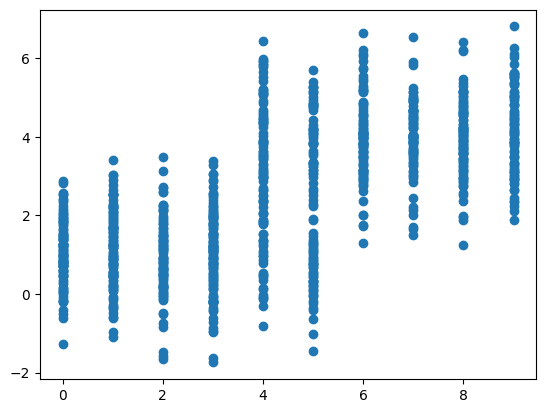

In [31]:
plt.scatter(X,Y)

In [75]:
def E_step(X,Y,P_t):
    """
    Compute the E step, find the model parameters for each period
    """
    mu = np.zeros(max(P_t))
    for i in range(max(P_t)):
        mu[i] = np.mean(Y[P_t == (i+1)])
        
    return mu

def state_number_to_array(state_number,pi):
    state_array = []
    for i in range(pi-1):
        state_array = [state_number%3] + state_array
        state_number = state_number // 3
    return [state_number] + state_array

def state_array_to_number(state_array):
    state_number = state_array[0]
    for val in state_array[1:]:
        state_number *= 3
        state_number += val
    return state_number

assert state_number_to_array(state_array_to_number([0,1,0]), 3) == [0,1,0]
assert state_array_to_number(state_number_to_array(123, 4)) == 123

def filter_by_year(X,Y,year):
    return Y[X == year]


def prev_states(state_number, pi):
    """
    States are numbered as base-3 numbers with Pi digits where Pi is the total number of states
    This function returns the legal previous states for a given state number
    """
    possible_prev_states = [state_number]
    state = state_number_to_array(state_number, pi)
    for i in range(len(state)):
        if state[i] > 0:
            sts = possible_prev_states.copy()
            for p in sts:
                possible_prev_states.append(p - 3 ** i)
    return possible_prev_states

print(prev_states(state_array_to_number([2,1,0]), 3))

def start_states(pi):
    states = [0]
    for i in range(pi):
        sts = states.copy()
        for state in sts:
            states.append(state + 3 ** i)
    return states[1:]

print([state_number_to_array(s,3) for s in start_states(3)])

def state_to_mu_index(state_number, pi):
    state_arr = state_number_to_array(state_number, pi)
    return np.array(state_arr) == 1

print(state_to_index(state_array_to_number([2,1,0]), 3))


def log_likelihood(Y_values, mu):
    """
    Compute the likelihood of the y-values under the mu values
    if mu is a list, compute likelihood under a mixture
    """
    if type(Y_values) is list: Y_values = np.array(Y_values)
    if type(mu) is not np.ndarray: mu = np.array(mu)
    if Y_values.ndim==1: # handle univariate case
        Y_values = Y_values.reshape([-1,1])
        mu = mu.reshape([-1,1])
    else:
        if mu.ndim == 1: mu.reshape([1,-1])
        assert mu.shape[1] == Y_values.shape[1]
    if type(mu) is not np.ndarray:
        return np.sum(scipy.stats.norm.logpdf(Y_values, loc=mu))
    else:
        total_ll = 0
        distances = np.zeros([len(Y_values), len(mu)])
        for i in range(len(mu)):
            distances[:,i] = np.linalg.norm(Y_values - mu[i].reshape([1,-1]), axis=1)
        center = np.argmin(distances,axis=1)
        for i in range(len(mu)):
            total_ll += np.sum(scipy.stats.norm.logpdf(Y_values[center == i], loc=mu[i]))
        return total_ll
    
print(log_likelihood([0], [0]))
print(log_likelihood(np.array([0,0.1,-0.1, 2.1, 2.2]), np.array([0,2])))
    

def M_step(X,Y,mu_t):
    """
    Compute the M step, find the maximum likelihood periodization, given those period means
    This requires dynamic programming
    """
    pi = len(mu_t)
    table = np.zeros(3 ** pi, max(X), dtype='float') + np.inf
    backtrack_table = np.zeros(3 ** pi, max(X)+1, dtype='int')
    Y_values_for_year_0 = filter_by_year(X,Y,0)
    for state in start_states(pi):
        table[0,state] = log_likelihood(y_values_for_year_0, mu_t[state_to_index(state)])
    
    for year in range(max(X)+1):
        y_values_for_year = filter_by_year(X,Y,year)
        for state in range(3 ** pi):
            valid_prev_states = prev_states(state, pi)
            if len(valid_prev_states) == 0: continue
            ll = log_likelihood(y_values_for_year, mu_t[state_to_index(state)])
            prev_state = np.argmin(table[year-1, valid_prev_states])
            table[state,year] = ll + table[year-1, prev_state]
            backtrack_table[state,year] = prev_state
            
    final_state = np.argmax(table[max(X)])
    state_sequence = [final_state]
    for i in range(len(backtrack_table), 0,-1):
        state_sequence = [backtrack_table[state_sequence[0],i]] + state_sequence
    return state_sequence


def state_sequence_to_period_weights(X,Y,state_sequence, mu):
    assignments = np.zeros([len(X), mu])
    for i in range(len(state_sequence)):
        relevant_means = mu[state_sequence_to_period_assignments(state_sequence)]
        relevant_indices = (X == i)
        

[21, 20, 18, 17]
[[0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
[False  True False]
-0.9189385332046727
-4.629692666023363
